In [19]:
import csv
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from math import sqrt
import analyze
from itertools import chain

In [65]:
f = open('data/states-daily.csv')
reader = csv.DictReader(f)
rows = []

num_cols = 24
def default():
  return np.zeros(shape=(num_cols,))
def intsafe(x):
  return int(x) if x != '' else -1
tests = defaultdict(default)
hosps = defaultdict(default)
deaths = defaultdict(default)
checked = defaultdict(default)
checked_all = np.zeros(shape=(num_cols,))
for row in reader:
    day = int(row['date']) - 20200301
    state = row['state']
    test_count = intsafe(row['positive'])
    checked_count = intsafe(row['totalTestResults'])
    death_count = intsafe(row['death'])
    hosp_count = intsafe(row['hospitalized'])
    tests[state][day] = test_count
    hosps[state][day] = hosp_count
    deaths[state][day] = death_count
    checked[state][day] = checked_count
    checked_all[day] += checked_count
print(checked["NY"])

[0.0000e+00 0.0000e+00 0.0000e+00 5.4000e+01 9.8000e+01 1.2500e+02
 1.6800e+02 1.9700e+02 2.3400e+02 2.6500e+02 3.0800e+02 3.0800e+02
 3.2000e+03 3.3030e+03 5.2720e+03 5.4930e+03 7.2060e+03 1.4597e+04
 2.2284e+04 3.2427e+04 4.5437e+04 6.1401e+04 7.8289e+04 9.1270e+04]


In [77]:
def calculate_growth(series, thresh=10, start=5):
  days = np.arange(0, series.shape[0])
  if ((series < thresh).all()):
    return None
  keep = (series >= start) & (series < 220000)
  series = series[keep]
  days = days[keep]
  if (days.shape[0] < 4):
    return None
  print(series)
  print(days)
  model = analyze.ExponentialGrowthRateEstimator(family='NegativeBinomial', alpha=None)
  model.fit(day=days, cases=series)
  print(np.diff(series))
  print(model.fitted_glm.mu)
  print(model.summary())
  est = model.growth_rate()
  low, high = model.growth_rate_confint()
  return (max(low, 0), est, high)

In [60]:
growths = dict()
dataset = hosps.items()
for k, v in dataset:
  #try:
  growth = calculate_growth(v, thresh = 20, start = 5)
  if growth:
    print(' (for %s)' % k)
    growths[k] = growth
  #except Exception:
  #  print('Failed to calculate for %s' % k)

[44. 49. 58. 72.]
[20 21 22 23]
[ 5.  9. 14.]
[ 5.20223076  8.59553848 14.20223076]
 (for CO)
[158. 185. 217. 259.]
[20 21 22 23]
[27. 32. 42.]
[26.44629327 33.10741347 41.44629327]
 (for FL)
[61. 71. 79. 94.]
[20 21 22 23]
[10.  8. 15.]
[ 8.59510813 10.80978374 13.59510813]
 (for MA)
[1603. 1974. 2635. 3234.]
[20 21 22 23]
[371. 661. 599.]
[433.66543134 535.66913732 661.66543134]
 (for NY)
[ 58.  83. 104. 145.]
[20 21 22 23]
[25. 21. 41.]
[21.37017872 28.25964256 37.37017872]
 (for OH)
[10. 11. 15. 25.]
[20 21 22 23]
[ 1.  4. 10.]
[ 1.22799813  3.54400375 10.22799813]
 (for OK)
[25. 32. 38. 45.]
[20 21 22 23]
[7. 6. 7.]
[6.66666667 6.66666667 6.66666667]
 (for VA)


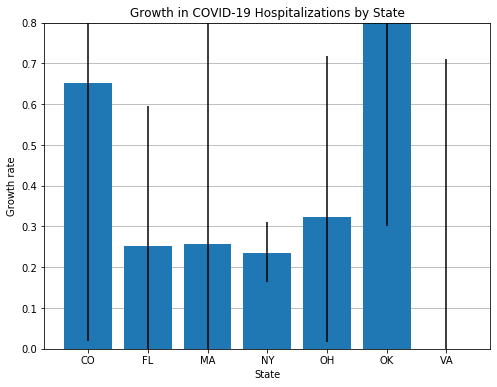

In [62]:
to_plot = growths#{k:v for k, v in growths.items() if k == 'WA'}
names = list(to_plot.keys())
err_l = list([v[1]-v[0] for v in to_plot.values()])
ests  = list([v[1] for v in to_plot.values()])
err_h = list([v[2]-v[1] for v in to_plot.values()])
errs = np.array([err_l, err_h])
plt.rcParams['axes.axisbelow'] = True
plt.bar(range(len(names)), ests, yerr=errs, align='center')
plt.ylim([0,0.8])
plt.grid(axis='y')
plt.xlabel('State')
plt.ylabel('Growth rate')
plt.title('Growth in COVID-19 Hospitalizations by State')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

plt.xticks(range(len(names)), names)
plt.show()

In [79]:
calculate_growth(checked_all, thresh = 20, start = 100)

[   866.   1129.   1794.   2150.   2752.   3951.   4585.   7123.   9356.
  15535.  19552.  25721.  40123.  53327.  73956. 100842. 135185. 179112.]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Using alpha = 0.00884200038359147
[  263.   665.   356.   602.  1199.   634.  2538.  2233.  6179.  4017.
  6169. 14402. 13204. 20629. 26886. 34343. 43927.]
[  293.0772976    404.46044144   558.17441348   770.30691742
  1063.05974028  1467.07239134  2024.62883305  2794.08292039
  3855.9657151   5321.41386624  7343.8011715  10134.79067822
 13986.4873371  19302.00970518 26637.68033239 36761.25047746
 50732.2529516 ]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                  

(0.3667917420999316, 0.3800469867778371, 0.3934307817725604)